<a href="https://colab.research.google.com/github/kamalchapagain/Kaggle_competition_solutions/blob/master/M5_Final_notebook_Oct12_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary of this notebook

**This notebook develope the M5-accuracy model, it is divided into six major parts where we discuss different techniques implemented by the Kaggle compititors** 
  - Part 1. Introduction of dataset
          - simple train_train split strategy to reduce the computational    
            burden of notebook
          - Sampling of available dataset
  - Part 2. Extrapolatory data analysis (EDA)
          - Downcasting the memory
          - Data imputation
          - Melting of the dataset
          - Data visualization
  - Part 3. Feature Engineering
          - Statistical feature for prices, min_max price, avg price, deviation 
            of price
          - Normalization (min/max scaling)
          - 'rolling' aggregation 
          - Momentum of the prices
          - Lag feature implementation
  - Part 4. Selection of model and parameters (Baseline model)
          - Construction of baseline model for feature engineering validation.
          - PCA implementation for dimension (of features) reduction strategy.
          - Feature engineering validataon by permutation importances.
  - Part 5. Encoding
          - Label encoding
          - One hot encoding
          - Feature hashing 
          - Categories encoding with dataset statistics
          - Target encoding (implemented one)
  - Part 6. Final forecasting
          - parallelization for FE
          - get the final_processed datasets
          - model selection (implementation)
          - Train the model (beware of data leakage)
          - Final forecasting

***The main objective of the competition was to produce the most accurate point forecast for 42840 time series that represent the hierarchical unit sales of one of the largest retail company, Walmart.*** 

**Highlights and contributions of forecasting competitions- Hyndman(2020)**

- Significantly expanding the number of participating machine learning methods.
- Includes exogenous/explanatory variables in addition to the time series data.
- Wider range of benchmarks (24 benchmarks models are available in the guideline) and datasets that are regularly updated to mitigate over-fitting in published data.
- Objective measures that are based on well-recognized attirbutes of the forecast distribution. 
- Forecast distribution performance should be assessed along with point forecast accuracy.
- Large-scale multivariate time-series forecasting should be considered to exploit possible cross-correlations between the series.
- High frequency data, such as hourly, daily, and weekly should be introduce to investigate how multple seasonal patterns are irregulalry spaced observations could be perperly handled.

- ***The improvement on the forecasting performance should come from***
    - Loss function
    - Data representation
    - Stable CV
    - Good features reduction strategy
    - Predictions stabilization with NN
    - Trend prediction
    - Real zero sales detection/classification

- *** The features created in these notebook is from***
    - **Mean encodings and PCA options** *https://www.kaggle.com/kyakovlev/m5-custom-features*
    - **Lags and rolling lags** https://www.kaggle.com/kyakovlev/m5-lags-features*
    - **Base Grid and base features (calendar/price/etc)** *https://www.kaggle.com/kyakovlev/m5-simple-fe*

In [11]:
#for plot
!pip install --upgrade plotly

     |████████████████████████████████| 13.1MB 294kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


#**Part 1 Introduction of dataset**

In [1]:
# General imports of Python library
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [2]:
# Import more libraries
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import warnings
warnings.filterwarnings('ignore')

In [1]:
from google.colab import files
from IPython.display import Image
uploaded=files.upload()

Saving DatasetInfo.png to DatasetInfo.png


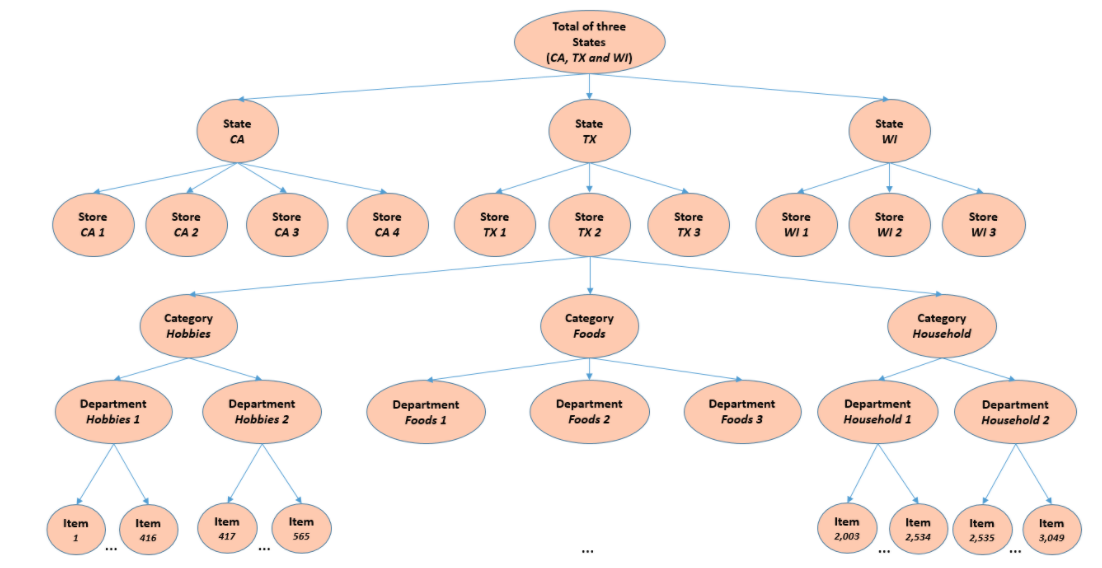

In [2]:
Image('DatasetInfo.png', width=1200)

This figure describes the overall dataset. For datials, we can visit Kaggle competitors guidelines (https://www.kaggle.com/c/m5-forecasting-accuracy/overview/timeline).  

In [3]:
########################### Load Data#####################
print('Loading the sampled Data')
path='/content/drive/My Drive/GoogleColab/'
train_df = pd.read_csv(path+'sales_train_evaluation.csv')
train_df.name='sales'
prices_df = pd.read_csv(path+'sell_prices.csv')
prices_df.name='prices'
calendar_df =pd.read_csv(path+'calendar.csv')
calendar_df.name='calendar'

Loading the sampled Data


In [4]:
print(train_df.shape, prices_df.shape, calendar_df.shape)

(30490, 1947) (6841121, 4) (1969, 14)


**This this dataset upto 1913 is used for validation purpose, therefor, for simplicity to undersand, we are going to change the column *id* contains *_evaluation into* _validation**

# Train-Validation-Test split Strategy for the dataset:

***The M5 competition was divided into two phases: Validataion phase, and test phase.

- **Validation phase:** During this phase, the teams were allowed to train their forecasting methods with the data initially provided by the organizer ( consisting 1913 days and validate the accuracy for the hidden sample (not publicaly available). This sample corresponeded to the four weeks succedding the initial train set, i.e d_1914 to d_1941. By Submitting their forecasts to the Kaggle platform, the teams were informed about the accuracy of their submission, which was then published onto Kaggle's real time leaderboard. In order to avoid over-fitting, the leaderboard should be used for assessing the methods developed and not for indirectly optimizing their settings (eg hyper parameter tuning and feature selection). Therefore the dataset can be divided as,

- **Test phase: (June 1, 2020 to June 28, 2020):** They were then asked to re-estimate or adjust their forecasting methods (if needed), in order to submit their final forecast for the following 28 days, 
  - *Training dataset (X_train): 2011-01-29(d_1) to 2016-03-17 (d_1885)* 

  - *Validation dataset (X_val): d_1886 to d_1913 (28 days)*

  - *Test dataset for evaluation (X_test): d_1914 to d_1941 (28 days)*

  - *and corresponding days is taken for y_train (d_1- d_1885) and y_val (d_1886-d_1913)*

  - *y_test (d_1914 to d1941) for 28 days is need to forecast and submit*


- **However, y_test dataset of first phase(d_1914 to d_1941) is already released for the second phase, therefore, we can modified the training/validation/testing dataset as,**

- *Training dataset (X_train): d_1 to d_1913)* 

- *Validation dataset (X_val): d_1914 to d_1941 (28 days)*

- *Test dataset for evaluation (X_test): d_1941 to d_1969 (28 days)*

- *and corresponding days is taken for y_train (d_1- d_1913) and y_val (d_1914-d_1941)*

In [5]:
train_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


**This this dataset upto 1913 is used for validation purpose, therefor, for simplicity to undersand, we are going to change the column *id* contains *_evaluation into* _validation**

In [6]:
import re
train_df.id.replace({'evaluation':'validation'}, regex=True, inplace=True)

In [7]:
train_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


#Technique 1. Sampling of Dataset:
  - **Category:** Sampling technique is categorized to the pre-processing stage where we can have sampled dataset from the population dataset.
  - **Description:** Large volumes of data need huge computation time, and possibility of memory exploded. Therefore, the analysis of a small dataset extracted from the original set is preferred. From this smal set, called sampled dataset, approximate result can be obtained.
  - **Situation:** The train-test split procedure is appropriate when we have a very large dataset. We can link sql procedure in Python for this purpose. However, train_test_split() function from sklearn library is used. Normally, this sampling technique is used to split the given dataset into train and test dataset. Normally, this sampling technique is used to split the given dataset into train and test dataset. The size of the split can be specified via the 'test size' argument that takes a number of rows(integer) or a percentage(float) of the size of dataset between 0 and 1. For example, X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.1, random_state=1). The values used in test_size=0.1 means 10 percent of the dataset will be allocated to the test set and 90 percent will be allocated to the training set.*

*As the technique (train_test_split) is implemented to divide the given dataset into training and testing dataset. But, we are implemented the same technique for the sampling a big dataset.*

*Unlike normal regression dataset, time-series dataset need the consistency of dataset with calendar dates, therefore, random sampling may alter these dates. This is the reason we must need careful management of sampled dataset. Eg-arrange the dataset according to calendar date, or reset the date with index is necessary.*

*Similary, for the classification problem if dataset is not the balanced for the balanced for each class level, such train_test_split() sampling may cause the biased result. The reason is unbalanced sampling from the train_test_split(). In this case data should be implement using the 'stratify' techniques. Eg- X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.1, random_state=1, stratify=y). The more detail about the tratify techniques is found at, https://www.kaggle.com/flaviobossolan/stratified-sampling-python.*    




In [8]:
# Reduction of dataset (just take 10% of dataset)
from sklearn.model_selection import train_test_split #library

def sampling_dataset(dataset):
# dataset: pandas dataframe for the population
# data_keep: sampled dataframe based on train_test_split (we will keep this for further processing)
# data_discard: sampled datafram that we remove (we will remove this dataset)
# train_size=0.1  : samples 10% of dataset from the popolation and store at variable data_keep
# random_state=42 : to reproduce same result

  data_keep, data_discard=train_test_split(dataset,train_size=0.1, random_state=42)
  print('Total size and sampled size')
  print(dataset.shape,data_keep.shape)
  data_keep.sort_index(inplace=True)
  data_keep.reset_index(drop=True, inplace=True)
  return data_keep

#eg-
train_df=sampling_dataset(train_df)
prices_df=sampling_dataset(prices_df)
train_df_for_lag_feature=train_df.copy() #Lets save train_df content for part 2.1 (lag features analysis)


Total size and sampled size
(30490, 1947) (3049, 1947)
Total size and sampled size
(6841121, 4) (684112, 4)


*Which is just the 10% of available sampled dataset. Few bloggers talking about 'Stratified sampling', however we implement train_test_split strategy with random state.*

In [9]:
########################### Vars ##############
TARGET = 'sales'         # Our main target
END_TRAIN = 1913         # Last day in train set, However new dataset contains upto d_1941
MAIN_INDEX = ['id','d']  # We can identify item by these columns


In [10]:
#Some user-defined functions, for later use
## Simple "Memory profilers" to see memory usage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

## Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

#**Part 2. Extrapolatory data analysis (EDA)**

#Technique 2: Downcasting the memory

- **Category:** datatype (data transformation)
- **Description:** Saving memory size can greatly reduce the burden to our system memory while improve our analysis experience. 
- **Situation:** Downcasting is the most important feature to reduce the dataset without losing any information. It also helps to accelerate our execution time. Therefore, several competitor perfomring the downcasting to save memory. Eg- https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data has discussed the importnace of downcast, and reduced the memory from 134.4MB to just 61.6MB using a simple code, 

- *As our datset consist the numerical, categorical, boolean etc., the treatment for these data as follow,*

- *The numerical columns:Depending on our environment, pandas automatically create int32, int64, float32 or float64 columns for numeric ones. If we know the min or max value of a column, you can use a subtype which is less memory consuming. We can also use an unsighed subtype if there is no negative value.*

    - *The different subtype we can use:,*
    - *int8/uint8: consumes 1 byte of memory, range between -128/127 or 0/255*
    - *bool: consumes 1 byte, true or false*
    - *float16/int16/uint16: consumes 2 bytes of memory*
    - *float32/int32/uint32: consumes 4 bytes of memory*
    - *float64/int64/uint64: consumes 8 bytes of memory*

  - *If one of our column has values between 1 and 10 for example, we will reduce the size of that column from 8 bytes per row to 1 byte, which is more than 85% memory saving on that column.*

  - *Pandas stores categorical columns as objects. This storage is not optimal because it creates a list of pointers to the memory address of each value of the column.*

  - *The categorica data type is useful becasue a string variable consisting of only a few different values. Converting such a string variable to a vategorical variable will save some memory. The lexical order of a variable is not the same as the logical order ('one', 'two', 'three'). By converting it to a categorical and specifying an order on the categories, sorting and min/max will use the logical order instead of the lexical order.* 

  - *For columns with low cardinality (the amount of unique values is lower than 50% of the count of these values), this can be optimized by forcing pandas to use a virtual mapping table where all unique values are mapped via an integer instead of a pointer. This is done using the category data-type.*

In [11]:
## Downcasting the memory 
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
  
###### For example #######
reduce_mem_usage(train_df, verbose=True);
#####Output#####
#Mem. usage decreased to 6.62Mb (85.4% reduction)

Mem. usage decreased to  6.62 Mb (85.4% reduction)


*where the memory usage is significantly reduced, approx(85.4%)*

#Technique 3: Data Imputation
- Category: pre-processing, data clearning
- Description: There are different ways how we handle the missing values. The simplest way of handling values is deleting the rows, if the row contains 70-80% of missing values. Removing the data will lead to loss information. Therefore, the easiest method of handling the missing value is mean/median/mode (statistical approach) imputation. This si the approximation which can add variance and bias to the dataset. However, it can prevent data loss. 

Using machine learning algorithm, we can predict the nulls from the given dataset. This technique may result in better accuracy, unless the missing value is expected to have a very high variance. 

- Situation: There should be the careful while we are handling numeric missing values or categorical missing values. We can not have the mean replacement for the categorical missing values. Als, in few cases, missing values or ero values also indicates some meaning. For example, if we have the house price prediction datase, some features such as swimming pool, AC services maybe present or absent on that particular house and consiquently the data is 0 or 1. In this case we need to haldle or treat each features individually.

- Code: 

Series([], dtype: float64)


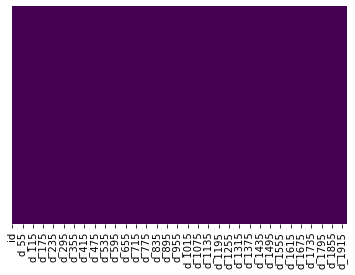

In [12]:
import seaborn as sns
def check_nulls(df):
  sns.heatmap(df.isnull(),yticklabels=False, cbar=False, cmap='viridis') #plot
  null_columns=df.columns[df.isnull().any()]
  df[null_columns].isnull().sum()
  print(df[null_columns].isnull().sum())

check_nulls(train_df)

In [13]:
# #We can use this data for as a good example,
# import pandas as pd
# path='/content/drive/My Drive/GoogleColab/HousePrices/'
# Null_imputation_df=pd.read_csv(path+'train.csv')

In [14]:
# example for null 
# import seaborn as sns
# def check_nulls(df):
#   sns.heatmap(df.isnull(),yticklabels=False, cbar=False, cmap='viridis') #plot
#   null_columns=df.columns[df.isnull().any()]
#   df[null_columns].isnull().sum()
#   print(df[null_columns].isnull().sum())

# check_nulls(Null_imputation_df)

In [15]:
#Null_imputation_df.select_dtypes(include=['object'])
#df_nan_float_features
#Null_imputation_df.info()

* Our dataset do not consist any missing values. However, most of the cases our data consist the null values, for that case we have prepared the function as,

In [16]:
# def missing_data_management(df):
#   null_columns=df.columns[df.isnull().any()] # select all the null columns
#   train_nans=df[null_columns] # Only NaN containing columns in dataframe df: these columns may consist cat/int/float
  
#   #which can be check by: df.info()
#   df_nan_cat_features=train_nans.select_dtypes(include=['object']).copy()
#   df_nan_float_features=train_nans.select_dtypes(include=['float64']).copy()

#   for i, t in enumerate(df_nan_cat_features): #to replace categorical
#     #print(t)
#     if df[t].isnull().sum()>=100:            # if more than 100 NaNs in that columns, dropout
#       df.drop([t], axis=1, inplace=True)
#     else:
#       df[t]=df[t].fillna(df[t].mode()[0])

#   for i, t in enumerate(df_nan_float_features): #to replace float
#     #print(t)
#     if df[t].isnull().sum()>=100:            # if more than 100 NaNs in that columns, dropout
#       df.drop([t], axis=1, inplace=True)
#     else:
#       df[t]=df[t].fillna(df[t].mean()[0])
#   return df

# #For example,
# Null_imputation_df=missing_data_management(Null_imputation_df)
# check_nulls(Null_imputation_df)



# Technique 4:  Melting of the dataset
- Melting of the dataset is simple, but quite useful technique where we transform the horizontal dataset into the vertical view.

- Out index will be *'id'*, *'item_id'*, *'dept_id'*, *'cat_id'*, *'store_id'*, *'state_id'* and labels are *'d_'* coulmns

In [17]:
########################### Making Grids (for prices/sales) ###################################
print('Melting the dataset to different grids')

index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
grid_df = pd.melt(train_df, 
                  id_vars = index_columns, 
                  var_name = 'd', 
                  value_name = TARGET)

#After melting, lets observe the train rows and columns
print('Train rows:', len(train_df), len(grid_df))

# To be able to make predictions we need to add "test set" to our grid
add_grid = pd.DataFrame()
for i in range(1,29):
    temp_df = train_df[index_columns]
    temp_df = temp_df.drop_duplicates()
    temp_df['d'] = 'd_'+ str(END_TRAIN+i)
    temp_df[TARGET] = np.nan
    add_grid = pd.concat([add_grid,temp_df])

grid_df = pd.concat([grid_df,add_grid])
grid_df = grid_df.reset_index(drop=True)

# Remove some temoprary DFs
del temp_df, add_grid

# We will not need original train_df anymore and can remove it
del train_df

# Let's check our memory usage
print("{:>20}: {:>8}".format('Size of grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

Melting the dataset to different grids
Train rows: 3049 5918109
     Size of grid_df: 366.4MiB


*We can free some memory by converting "strings" to categorical which will not affect merging and we will not lose any valuable data*

In [18]:
for col in index_columns:
    grid_df[col] = grid_df[col].astype('category')

# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

     Reduced grid_df: 137.6MiB


# Technique 5: Data Visualization
 - Category: EDA, Feature Selection
 - Description: Data visualization is the key stage for feature selection, feature extraction, and classification of datasets. In order to visualize the data, Seaborn, Plotly, or mostly violin plots and swarm plots are the choice of competitors. For the consistency of the plot, we need to normalize or standardize the dataset. Because the differences between values of features are very high to observe on plot.
 - Situation: In some cases, we do need the standardization or normalization before visualization, feature selection, feature extraction. However, correlation plot ('magma') or matrix is also a good option. For the detail discussion of visualization, we can follow the given link in Kaggle. https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization.

 - Code 

In [19]:
# Lets melt again, for EDA
# wide format: melt function

df = pd.melt(train_df_for_lag_feature, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales').dropna()
## merging with calendar and prices
df = pd.merge(df, calendar_df, on='d', how='left')
df = pd.merge(df, prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')

In [20]:
#details of sales
group = train_df_for_lag_feature.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)['item_id'].count().dropna()
group['USA'] = 'United States of America'
group.rename(columns={'state_id':'State','store_id':'Store','cat_id':'Category','dept_id':'Department','item_id':'Count'},inplace=True)
#details of sales data
fig = px.treemap(group, path=['USA', 'State', 'Store', 'Category', 'Department'], values='Count',
                  color='Count', color_continuous_scale= px.colors.sequential.Sunset, title='Walmart: Distribution of items')
fig.update_layout(template='seaborn')
fig.show()

In [21]:
#price of individual store
group_price_store = df.groupby(['state_id','store_id','item_id'],as_index=False)['sell_price'].mean().dropna()
#item price and their distribution. 
fig = px.violin(group_price_store, x='store_id', color='state_id', y='sell_price',box=True, hover_name='item_id')
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Selling Price($)')
fig.update_layout(template='seaborn',title='Distribution of Items prices for each Stores',legend_title_text='State')
fig.show()

In [22]:
#price of each categories
group_price_cat = df.groupby(['store_id','cat_id','item_id'],as_index=False)['sell_price'].mean().dropna()

#Distribution of price according to the categories
fig = px.violin(group_price_cat, x='store_id', color='cat_id', y='sell_price',box=True, hover_name='item_id')
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Selling Price($)')
fig.update_layout(template='seaborn',title='Distribution of Items prices wrt Stores across Categories',
                 legend_title_text='Category')
fig.show()

The violin plot is one of the best methodology to describe the distribution of dataset. Most of the cases, mean and median may not enough to understand the dataset. One option is either box-plot or the kernel density plot. However, violin plot added one more information about the median by introducing the 'wideness' (seems like violin shape). The Wider sections of the violin plot represent a higher probability of that members (mean) of the population will take on the given value; the skinnier sections represent a lower probability.

Since we have few dataset, most of our information is hiding. In general, The distribution of item prices is almost uniform for all the stores across Califoria, Texas and Wisconsin. However, comparatively, price of Household_2_446 at TX_3 sold in high price (28 dollars). The price of HOUSEHOLD is expensive in all the states.

In California: CA_3 has sold the most number of items while, CA_4 has sold the least number of items.
In Texas: TX_2 have sold the maximum number of items. while TX_1 and TX_3 has sold the equal number of items.
Wisconsin: WI_3 has sold the maximum number of items while, sales of WI_1 consist high variation compared to WI_3

In overall CA_3 and WI_3 have sold the most number of items while, CA_4 has sold the least number of items.

In [23]:
#dawise sales
group_item_sold_daywise = df.groupby(['weekday','date','state_id','store_id'], as_index=False)[TARGET].sum().dropna()

#Distribution of items sales for each states on individual days
fig = px.violin(group_item_sold_daywise, x='weekday', color='state_id', y=TARGET,box=True)
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Total items sold')
fig.update_layout(template='seaborn',title='Distribution of Items sold in each Stores',legend_title_text='State')
fig.show()

Item sold over the time: for all the stores
Let's study number of items sold over time across all the stores.

Weekdays has the maximum sales in all three states, comparatively higher in California and WI.

In [24]:
df.date.min()

'2011-01-29'

In [25]:
#Select the range
import datetime as datetime
# START_DATE=format(df.date.min().date())
# END_DATE=format(df.date.max().date())

# print('Range of dates: %s to %s' %(START_DATE, END_DATE))

START_DATE=df.date.min()
END_DATE=df.date.max()

print('Range of dates: %s to %s' %(START_DATE, END_DATE))

Range of dates: 2011-01-29 to 2016-05-22


In [26]:
def timeseries_plot(group_item_sold):
  fig = go.Figure()
  title = 'Items sold over time'
  years = group_item_sold.year.unique().tolist()
  buttons = []
  y=3
  for state in group_item_sold.state_id.unique().tolist():
      group_state = group_item_sold[group_item_sold['state_id']==state]
      for store in group_state.store_id.unique().tolist():
          group_state_store = group_state[group_state['store_id']==store]
          fig.add_trace(go.Scatter(name=store, x=group_state_store['date'], y=group_state_store['sales'], showlegend=True, 
                                    yaxis='y'+str(y) if y!=1 else 'y'))
      y-=1

  fig.update_layout(
          xaxis=dict(
          #autorange=True,
          range = [START_DATE,END_DATE],
          rangeselector=dict(
              buttons=list([
                  dict(count=1,label="1m",step="month",stepmode="backward"),
                  dict(count=6,label="6m",step="month",stepmode="backward"),
                  dict(count=1,label="YTD",step="year",stepmode="todate"),
                  dict(count=1,label="1y",step="year",stepmode="backward"),
                  dict(count=2,label="2y",step="year",stepmode="backward"),
                  dict(count=3,label="3y",step="year",stepmode="backward"),
                  dict(count=4,label="4y",step="year",stepmode="backward"),
                  dict(step="all")])),rangeslider=dict(autorange=True,),type="date"),
      yaxis=dict(anchor="x",autorange=True,domain=[0, 0.33],mirror=True,showline=True,side="left",tickfont={"size":10},tickmode="auto",ticks="",title='WI',titlefont={"size":20},type="linear",zeroline=False),
      yaxis2=dict(anchor="x",autorange=True,domain=[0.33, 0.66],mirror=True,showline=True,side="left",tickfont={"size":10},tickmode="auto",ticks="",title = 'TX',titlefont={"size":20},type="linear",zeroline=False),
      yaxis3=dict(anchor="x",autorange=True,domain=[0.66, 1],mirror=True,showline=True,side="left",tickfont={"size":10},tickmode="auto",ticks='',title="CA",titlefont={"size":20},type="linear",zeroline=False))
  fig.update_layout(template='seaborn', title=title)
  fig.show()

#sales items
group_item_sold = df.groupby(['year','date','state_id','store_id'], as_index=False)['sales'].sum().dropna()
timeseries_plot(group_item_sold)


#Adding some more Features:

- The sales data (Target) contains several zeros. The meaning of this zero is no sales of that product. But, there are several reasons behind this zero. For example, if there is the absent of that product in the store, there is no sales of that product eventhough the demand of that product is high. Therefore, we should construct few more *features* from *prices_df* for example, 'product released week.

- Also this absence of the item (product) denoted by zeros, can be remove to save the memory.

In [27]:
########################### Product Release date ###############################
print('Release week')

# Prices are set by week so it we will have not very accurate release week 
release_df = prices_df.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index()
release_df.columns = ['store_id','item_id','release']

# Now we can merge release_df
grid_df = merge_by_concat(grid_df, release_df, ['store_id','item_id'])
del release_df

# We want to remove some "zeros" rows from grid_df to do it we need wm_yr_wk column
# let's merge partly calendar_df to have it
grid_df = merge_by_concat(grid_df, calendar_df[['wm_yr_wk','d']], ['d'])
                      
# Now we can cutoff some rows and safe memory 
grid_df = grid_df[grid_df['wm_yr_wk']>=grid_df['release']]
grid_df = grid_df.reset_index(drop=True)

# Let's check our memory usage
print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

# Should we keep release week as one of the features? for now, lets keep release feature by reducing the memory size int16.

grid_df['release'] = grid_df['release'] - grid_df['release'].min()
grid_df['release'] = grid_df['release'].astype(np.int16)

# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

Release week
    Original grid_df: 174.9MiB
     Reduced grid_df: 148.7MiB


In [28]:
########################### Save part 1 ################
print('Save Part 1')
print('Part 1 is ready')

# We have our BASE grid ready and can save it as pickle file for future use (model training)
grid_df.to_pickle('/content/drive/My Drive/GoogleColab/pickle_files/grid_part_1.pkl')

print('Size:', grid_df.shape)
grid_part_1=grid_df.copy() #save in the name of grid_part_1

Save Part 1
Part 1 is ready
Size: (4578794, 10)


In [29]:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4578794 entries, 0 to 4578793
Data columns (total 10 columns):
 #   Column    Dtype   
---  ------    -----   
 0   id        category
 1   item_id   category
 2   dept_id   category
 3   cat_id    category
 4   store_id  category
 5   state_id  category
 6   d         object  
 7   sales     float64 
 8   release   int16   
 9   wm_yr_wk  int64   
dtypes: category(6), float64(1), int16(1), int64(1), object(1)
memory usage: 148.7+ MB


#**Part 3. Feature Engineering**
- **Some basic FE for prices are:** 
- statistical feature for prices are: min_price, max_price, average price, deviation in price
- Normalization (min/max scaling)
- "rolling" aggregations but would like months and years as "window"
- Momentum of the prices

In [30]:
print('Feature Engineering of Prices')

def feature_engineering_prices(dff, groupby_list, groupby_on):
# dff: dataframe (prices_df); 
# groupby_list: list of columns selection for grouping (['store_id', 'item_id']); 
# groupby_on: 'sale_price'

  # We can do some basic aggregations
  dff['price_max'] = dff.groupby(groupby_list)[groupby_on].transform('max')
  dff['price_min'] = dff.groupby(groupby_list)[groupby_on].transform('min')
  dff['price_std'] = dff.groupby(groupby_list)[groupby_on].transform('std')
  dff['price_mean'] = dff.groupby(groupby_list)[groupby_on].transform('mean')

  # and do price normalization (min/max scaling)
  dff['price_norm'] = dff[groupby_on]/dff['price_max']

  # Some items are can be inflation dependent and some items are very "stable"
  dff['price_nunique'] = dff.groupby(groupby_list)[groupby_on].transform('nunique')
  dff['item_nunique'] = dff.groupby(['store_id','sell_price'])['item_id'].transform('nunique')

  # we would like some "rolling" aggregations but would like months and years as "window"
  calendar_prices = calendar_df[['wm_yr_wk','month','year']]
  calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
  dff = dff.merge(calendar_prices[['wm_yr_wk','month','year']], on=['wm_yr_wk'], how='left')

 
  # Now we can add price "momentum" (some sort of) Shifted by week, by month mean, and by year mean
  dff['price_momentum'] = dff[groupby_on]/dff.groupby(groupby_list)[groupby_on].transform(lambda x: x.shift(1))
  dff['price_momentum_m'] = dff[groupby_on]/dff.groupby(['store_id','item_id','month'])[groupby_on].transform('mean')
  dff['price_momentum_y'] = dff[groupby_on]/dff.groupby(['store_id','item_id','year'])[groupby_on].transform('mean')
  del dff['month'], dff['year']

  return dff
#For eg-
groupby_list=prices_df.columns[0:2].tolist()
prices_df=feature_engineering_prices(dff=prices_df, groupby_list=groupby_list, groupby_on='sell_price')


Feature Engineering of Prices


In [31]:
# ########################### Prices ############################################
# print('Feature Engineering of Prices')

# # We can do some basic aggregations
# prices_df['price_max'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('max')
# prices_df['price_min'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('min')
# prices_df['price_std'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('std')
# prices_df['price_mean'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('mean')

# # and do price normalization (min/max scaling)
# prices_df['price_norm'] = prices_df['sell_price']/prices_df['price_max']

# # Some items are can be inflation dependent and some items are very "stable"
# prices_df['price_nunique'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('nunique')
# prices_df['item_nunique'] = prices_df.groupby(['store_id','sell_price'])['item_id'].transform('nunique')

# # we would like some "rolling" aggregations but would like months and years as "window"
# calendar_prices = calendar_df[['wm_yr_wk','month','year']]
# calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
# prices_df = prices_df.merge(calendar_prices[['wm_yr_wk','month','year']], on=['wm_yr_wk'], how='left')
# #del calendar_prices

# # Now we can add price "momentum" (some sort of) Shifted by week, by month mean, and by year mean
# prices_df['price_momentum'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id'])['sell_price'].transform(lambda x: x.shift(1))
# prices_df['price_momentum_m'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
# prices_df['price_momentum_y'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')

# #del prices_df['month'], prices_df['year']


In [32]:
########################### Merge prices and save part 2 #################################################
print('Merge prices and save part 2')

# Merge Prices
original_columns = list(grid_df)
grid_df = grid_df.merge(prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')
keep_columns = [col for col in list(grid_df) if col not in original_columns]
grid_df = grid_df[MAIN_INDEX+keep_columns]
grid_df = reduce_mem_usage(grid_df)

# Safe part 2
grid_df.to_pickle('/content/drive/My Drive/GoogleColab/pickle_files/grid_part_2.pkl')
print('Size:', grid_df.shape)
grid_part_2=grid_df.copy()

# We don't need prices_df anymore
del prices_df

Merge prices and save part 2
Mem. usage decreased to 174.77 Mb (62.3% reduction)
Size: (4578794, 13)


In [33]:
grid_part_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4578794 entries, 0 to 4578793
Data columns (total 13 columns):
 #   Column            Dtype   
---  ------            -----   
 0   id                category
 1   d                 object  
 2   sell_price        float16 
 3   price_max         float16 
 4   price_min         float16 
 5   price_std         float16 
 6   price_mean        float16 
 7   price_norm        float16 
 8   price_nunique     float16 
 9   item_nunique      float16 
 10  price_momentum    float16 
 11  price_momentum_m  float16 
 12  price_momentum_y  float16 
dtypes: category(1), float16(11), object(1)
memory usage: 174.8+ MB


In [34]:
calendar_df.columns

Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object')

In [35]:

########################### Lets Merge the calendar ###########################

grid_df = grid_df[MAIN_INDEX]

# Merge calendar partly 
icols = ['date',
         'd',
         'event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI']

grid_df = grid_df.merge(calendar_df[icols], on=['d'], how='left')

# Again, lets minify data
# 'snap_' columns we can convert to bool or int8
icols = ['event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI']
for col in icols:
    grid_df[col] = grid_df[col].astype('category')

# Convert to DateTime
grid_df['date'] = pd.to_datetime(grid_df['date'])

# Make some features from date
grid_df['tm_d'] = grid_df['date'].dt.day.astype(np.int8)
grid_df['tm_w'] = grid_df['date'].dt.week.astype(np.int8)
grid_df['tm_m'] = grid_df['date'].dt.month.astype(np.int8)
grid_df['tm_y'] = grid_df['date'].dt.year
grid_df['tm_y'] = (grid_df['tm_y'] - grid_df['tm_y'].min()).astype(np.int8)
grid_df['tm_wm'] = grid_df['tm_d'].apply(lambda x: ceil(x/7)).astype(np.int8)

grid_df['tm_dw'] = grid_df['date'].dt.dayofweek.astype(np.int8)
grid_df['tm_w_end'] = (grid_df['tm_dw']>=5).astype(np.int8)

# Remove date
del grid_df['date']

In [36]:

########################### Save part 3 (Dates) ###########################
print('Save part 3')

grid_df.to_pickle('/content/drive/My Drive/GoogleColab/pickle_files/grid_part_3.pkl')
print('Size:', grid_df.shape)

grid_part_3=grid_df.copy()

del calendar_df
del grid_df

Save part 3
Size: (4578794, 16)


In [37]:
grid_part_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4578794 entries, 0 to 4578793
Data columns (total 16 columns):
 #   Column        Dtype   
---  ------        -----   
 0   id            category
 1   d             object  
 2   event_name_1  category
 3   event_type_1  category
 4   event_name_2  category
 5   event_type_2  category
 6   snap_CA       category
 7   snap_TX       category
 8   snap_WI       category
 9   tm_d          int8    
 10  tm_w          int8    
 11  tm_m          int8    
 12  tm_y          int8    
 13  tm_wm         int8    
 14  tm_dw         int8    
 15  tm_w_end      int8    
dtypes: category(8), int8(7), object(1)
memory usage: 139.8+ MB


In [38]:
########################### Some additional cleaning (converting 'd' into int)
#################################################################################

## Part 1
# Convert 'd' to int
grid_df = grid_part_1.copy()
grid_df['d'] = grid_df['d'].apply(lambda x: x[2:]).astype(np.int16)

path='/content/drive/My Drive/GoogleColab/pickle_files/'
grid_df.to_pickle(path+'grid_part_1.pkl')

# Remove 'wm_yr_wk'
# as test values are not in train set
del grid_df['wm_yr_wk']
grid_part_1=grid_df.copy()

del grid_df

In [39]:
# lets concat all three grids for further processing

grid_df=pd.concat([grid_part_1, grid_part_2.iloc[:,2:], grid_part_3.iloc[:,2:]], axis=1)

# Let's check again memory usage
print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
print('Size:', grid_df.shape)

#           Full Grid:   157.4 MiB

#Still memory usage is high, we can train by state_id or shop_id !!

state_id = 'CA'
grid_df = grid_df[grid_df['state_id']==state_id]
print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
# Full Grid:  75.3MiB

store_id = 'CA_1'
grid_df = grid_df[grid_df['store_id']==store_id]
print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
#           Now, Full Grid: 19.2 MiB

           Full Grid: 244.7MiB
Size: (4578794, 34)
           Full Grid: 109.4MiB
           Full Grid:  27.8MiB


In [40]:
########################### Final list of features
#################################################################################
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451999 entries, 0 to 4576039
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   id                451999 non-null  category
 1   item_id           451999 non-null  category
 2   dept_id           451999 non-null  category
 3   cat_id            451999 non-null  category
 4   store_id          451999 non-null  category
 5   state_id          451999 non-null  category
 6   d                 451999 non-null  int16   
 7   sales             443739 non-null  float64 
 8   release           451999 non-null  int16   
 9   sell_price        46182 non-null   float16 
 10  price_max         46182 non-null   float16 
 11  price_min         46182 non-null   float16 
 12  price_std         46182 non-null   float16 
 13  price_mean        46182 non-null   float16 
 14  price_norm        46182 non-null   float16 
 15  price_nunique     46182 non-null   float16 
 16  i

In [41]:
#Lets load the sales dataset
train_df=train_df_for_lag_feature.copy() #This 'train_df_for_lag_feature' variable was already saved while sampling

In [42]:
# To make all calculations faster, we will limit dataset by 'CA' state
train_df = train_df[train_df['state_id']=='CA']
print('Shape is: %s' %str(train_df.shape))

Shape is: (1202, 1947)



*Here the number of features are d_1 to d_1941 (but we will consider upto d_1912) i.e a lot of feature, which is good, but we have just 1202 training rows (however we are taking only for CA)*

*In other hand we can think of d_ columns as additional labels and can significantly scale up our training set*

In [43]:
## Horizontal representation to vertical representation (tranformation)
train_df.iloc[:10]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2,0,2,0,2,1,0,0,0,0,0,0,0,0,2,0,2,1,0,0,1,0,0,1,0,2,1,1,0,0,1
1,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,0,2,0,0,0,0,0,2,0,0,0,2,0,0,0,2,0,3,0,1,1,3,1,1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0
2,HOBBIES_1_014_CA_1_validation,HOBBIES_1_014,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,3,0,2,2,1,2,0,0,3,1,1,1,0,0,2,3,0,3,5,1,3,1,4,1,2,1,1,0,2,1,1,1,0,2,2,1,1,1,3
3,HOBBIES_1_056_CA_1_validation,HOBBIES_1_056,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2,2,2,4,0,1,1,1,1,0,1,0,1,0,0,6,4,2,0,0,0,0,0,4,3,2,2,4,1,1,1,0,0,0,0,1,0,0,0
4,HOBBIES_1_062_CA_1_validation,HOBBIES_1_062,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1
5,HOBBIES_1_080_CA_1_validation,HOBBIES_1_080,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,1,0,0,0,2,0,0,0,0,0,9,0,0,0,0,1,0,0,0,0,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,12,2,0,0,7,0,0,4,0,0,0,13,5,0,0,0,3,0,5,0,2,0,0,3,4,1,1,3,0,0,0,0,0
6,HOBBIES_1_092_CA_1_validation,HOBBIES_1_092,HOBBIES_1,HOBBIES,CA_1,CA,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,HOBBIES_1_110_CA_1_validation,HOBBIES_1_110,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,2,0,0,0,0,0,0,0
8,HOBBIES_1_122_CA_1_validation,HOBBIES_1_122,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,5,2,11,2,0,7,3,2,0,0,0,9,0,3,0,1,4,1,0,0,0,0,4
9,HOBBIES_1_130_CA_1_validation,HOBBIES_1_130,HOBBIES_1,HOBBIES,CA_1,CA,4,3,4,3,0,1,0,0,0,3,0,0,2,4,0,3,0,0,0,1,2,5,0,3,2,1,0,2,1,1,1,0,2,1,...,0,3,1,0,0,3,1,4,0,2,0,1,1,0,0,0,1,2,0,0,0,0,5,2,0,1,0,0,0,3,1,0,1,0,0,1,0,3,1,3


Lets go for Vertical representation:

In other hand we can think of d_ columns as additional labels and can significantly
scale up our training set to 2333082 rows with 8 columns

Good thing that our model will have greater input for training

Bad thing that we are losing lags that we had in horizontal representation and

also new data set consumes much more memory

In [44]:
index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
train_df = pd.melt(train_df, 
                  id_vars = index_columns, 
                  var_name = 'd', 
                  value_name = TARGET)

train_df[train_df['id']=='HOBBIES_1_010_CA_1_validation'].iloc[:10]

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1202,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0
2404,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_3,1
3606,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0
4808,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0
6010,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_6,0
7212,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_7,0
8414,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_8,0
9616,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0
10818,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_10,0


# Technique 6: Lag feature implementation

Category: Data Transformation

Description: A lag features are the classical way to transform a time series forecasting problems into the supervised learning problems. The reason behind the conversion of time series into supervised learings are-
  - to convert a simple sequence to a pair of sequence inputs and outputs for machine learning purpose
  - time component makes time series problems difficult to handle.

Technically, in time series forecasting terminology the current time (t) and future times (t+1, t+2, ...) are forecast times and past observations (t+1, t+2, ...) are used to make forecasts. A lag feature can be created when we have data for a group across multiple time steps. For a given time-step, it records the value of the feature at a previous time step. For example, say we have a dataset with data on an individual's temperature at 9am each day. Our goal in modeling is to predict the individuals temperature on the next day. A lag feature could be added which contains the inviduals temperature on the next day. A lag feature could be added which contains the individual's temperature on the previous day. Any lag value can be used provided there is sufficient data (eg 1 day, 2 day, 3 day, etc).

Situation: Lag features can only be used for datasets which have data for a single group across multiple time steps. They can not be used in situations where the data has no time components, where there is a time component but the groups are not consistent across time, or where there is a time component but the lag interval (eg- 1 day) can not be consistently applied across the groups (eg because for some individuals we only have data every 3 days).

For the lag creation our dataset is allready sorted by d values
now, we can simply shift() values also we have to keep in mind that we need to aggregate values on 'id' level

Code: The pandas library provides the shift() function to create the lags from a time series dataset.


In [45]:
def lag_features(dff, feature, lags):
  #dff: dataframe (sales_df)
  #feature: list of features for lag
  #lags: number of lags

  temp_df = dff[['id','d',feature]]
  LAG_DAYS = [col for col in range(1,lags)]


  start_time = time.time()
  temp_df = temp_df.assign(**{
          '{}_lag_{}'.format(col, l): temp_df.groupby(['id'])[col].transform(lambda x: x.shift(l))
          for l in LAG_DAYS
          for col in [TARGET]
      })

  print('%0.2f min: Time for bulk shift' % ((time.time() - start_time) / 60))

  return temp_df

##For example,
dff=lag_features(dff=train_df, feature=TARGET, lags=8)

0.17 min: Time for bulk shift


In [46]:
# The result
dff[dff['id']=='HOBBIES_1_010_CA_1_validation'].iloc[:10]

,id,d,sales,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7
0,HOBBIES_1_010_CA_1_validation,d_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202,HOBBIES_1_010_CA_1_validation,d_2,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2404,HOBBIES_1_010_CA_1_validation,d_3,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3606,HOBBIES_1_010_CA_1_validation,d_4,0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
4808,HOBBIES_1_010_CA_1_validation,d_5,0,0.0,1.0,0.0,0.0,NaN,NaN,NaN
6010,HOBBIES_1_010_CA_1_validation,d_6,0,0.0,0.0,1.0,0.0,0.0,NaN,NaN
7212,HOBBIES_1_010_CA_1_validation,d_7,0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
8414,HOBBIES_1_010_CA_1_validation,d_8,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9616,HOBBIES_1_010_CA_1_validation,d_9,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10818,HOBBIES_1_010_CA_1_validation,d_10,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [47]:
# ## OR Same thing can be perform in another simple way, 

# ## Rolling lag

# def rolling_lag(dff,feature,lag):
#   start_time = time.time()
#   for i in range(1,lag):
#       print('Shifting:', i)
#       dff['lag_'+str(i)] = dff.groupby(['id'])[feature].transform(lambda x: x.shift(i))
      
#   print('%0.2f min: Time for loops' % ((time.time() - start_time) / 60))
#   return dff

# dff=rolling_lag(dff=train_df,feature=TARGET, lag=8)

# The result
#dff[dff['id']=='HOBBIES_1_010_CA_1_validation'].iloc[:10]

- **Insights:**

We can notice many NaNs values - which is normal because there is no data for day 0,-1,-2 (out of dataset time periods)

Same works for test set

be careful to make lag features:

*for day 1920 there is no data about day 1919 (until 1913) So if we want to predict day 1915, our lag features have to start from 2 (1915 (which is the predicting day)-1913 (the last day with label in dataset), and so on

#Rolling lags

Because of computational limitation, we restored few days of sales values from horizontal representation as lag features

*lambda x: x.shift(1)==> 1 day shift will serve only to predict day 1914*

for other days we have to shift PREDICT_DAY-1913

Lets go for rolling aggregation

In [49]:
def rolling_aggregation(dff,feature,lags):
  # dff: dataframe (sales_df):
  # feature: list of feature for lag
  # lags: specific numbers of lag
    # we simply shift() values also we have to keep in mind that we need 
    # to aggregate values on 'id' level

  dff = dff[['id','d',feature]]
  start_time = time.time()
  for i in lags:
    print('Rolling period:', i)
    dff['rolling_mean_'+str(i)] = dff.groupby(['id'])[feature].transform(lambda x: x.shift(1).rolling(i).mean())
    dff['rolling_std_'+str(i)]  = dff.groupby(['id'])[feature].transform(lambda x: x.shift(1).rolling(i).std())

  # we can also aggregate by max/skew/median etc 

  print('%0.2f min: Time for loop' % ((time.time() - start_time) / 60))

  return dff

#Eg:
dff=rolling_aggregation(dff, feature=TARGET, lags=[14,30,60])

Rolling period: 14
Rolling period: 30
Rolling period: 60
0.18 min: Time for loop


In [ ]:
# ########################### Rolling lags ###########################################################

# ## Rolling aggregations



# # Such aggregations will help us to restore
# # at least part of the information for our model

# temp_df = train_df[['id','d','sales']]

# start_time = time.time()

# for i in [14,30,60]:
#     print('Rolling period:', i)
#     temp_df['rolling_mean_'+str(i)] = temp_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(1).rolling(i).mean())
#     temp_df['rolling_std_'+str(i)]  = temp_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(1).rolling(i).std())

# # we can also aggregate by max/skew/median etc 

# print('%0.2f min: Time for loop' % ((time.time() - start_time) / 60))

In [51]:
# The result 
dff[dff['id']=='HOBBIES_1_012_CA_1_validation'].iloc[:20]

# Same as before, the NaNs values - is is because of absence of data for 
# 0*(rolling_period),-1*(rolling_period),-2*(rolling_period)

,id,d,sales,rolling_mean_14,rolling_std_14,rolling_mean_30,rolling_std_30,rolling_mean_60,rolling_std_60
1,HOBBIES_1_012_CA_1_validation,d_1,0,NaN,NaN,NaN,NaN,NaN,NaN
1203,HOBBIES_1_012_CA_1_validation,d_2,2,NaN,NaN,NaN,NaN,NaN,NaN
2405,HOBBIES_1_012_CA_1_validation,d_3,0,NaN,NaN,NaN,NaN,NaN,NaN
3607,HOBBIES_1_012_CA_1_validation,d_4,0,NaN,NaN,NaN,NaN,NaN,NaN
4809,HOBBIES_1_012_CA_1_validation,d_5,0,NaN,NaN,NaN,NaN,NaN,NaN
6011,HOBBIES_1_012_CA_1_validation,d_6,0,NaN,NaN,NaN,NaN,NaN,NaN
7213,HOBBIES_1_012_CA_1_validation,d_7,0,NaN,NaN,NaN,NaN,NaN,NaN
8415,HOBBIES_1_012_CA_1_validation,d_8,2,NaN,NaN,NaN,NaN,NaN,NaN
9617,HOBBIES_1_012_CA_1_validation,d_9,0,NaN,NaN,NaN,NaN,NaN,NaN
10819,HOBBIES_1_012_CA_1_validation,d_10,0,NaN,NaN,NaN,NaN,NaN,NaN


'Memory usage' minify mechanism

In [52]:
########################### Memory ussage ###################################################
# Let's check our memory usage
temp_df=dff.copy()
print("{:>20}: {:>8}".format('Original rolling df',sizeof_fmt(temp_df.memory_usage(index=True).sum())))

# can we minify it?
# 1. if our dataset are aligned by index 
#    we don't need 'id' 'd' 'sales' columns
temp_df = temp_df.iloc[:,3:]
print("{:>20}: {:>8}".format('Values rolling df',sizeof_fmt(temp_df.memory_usage(index=True).sum())))

# can we make it even smaller?
# yes, carefully change dtype and/or use sparce matrix to minify 0s
# Also note that lgbm accepts matrixes as input that is good for memory reducion 
from scipy import sparse 
temp_matrix = sparse.csr_matrix(temp_df)

# restore to df
temp_matrix_restored = pd.DataFrame(temp_matrix.todense())
restored_cols = ['roll_' + str(i) for i in list(temp_matrix_restored)]
temp_matrix_restored.columns = restored_cols

 Original rolling df: 160.2MiB
   Values rolling df: 106.8MiB


In [53]:
########################### Remove old objects
#################################################################################
del temp_df, train_df, temp_matrix, temp_matrix_restored

In [54]:
########################### Apply on grid_df #####################################################
# lets read first grid from 
grid_df = pd.read_pickle('/content/drive/My Drive/GoogleColab/pickle_files/grid_part_1.pkl')

# We need only 'id','d','sales'
# to make lags and rollings
grid_df = grid_df[['id','d','sales']]
SHIFT_DAY = 28

# Lags
# with 28 day shift
start_time = time.time()
print('Create lags')

LAG_DAYS = [col for col in range(SHIFT_DAY,SHIFT_DAY+15)]
grid_df = grid_df.assign(**{
        '{}_lag_{}'.format(col, l): grid_df.groupby(['id'])[col].transform(lambda x: x.shift(l))
        for l in LAG_DAYS
        for col in [TARGET]
    })

# Minify lag columns
for col in list(grid_df):
    if 'lag' in col:
        grid_df[col] = grid_df[col].astype(np.float16)

print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

# Rollings
# with 28 day shift
start_time = time.time()
print('Create rolling aggs')

for i in [7,14,30,60,180]:
    print('Rolling period:', i)
    grid_df['rolling_mean_'+str(i)] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
    grid_df['rolling_std_'+str(i)]  = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)

# Rollings
# with sliding shift
for d_shift in [1,7,14]: 
    print('Shifting period:', d_shift)
    for d_window in [7,14,30,60]:
        col_name = 'rolling_mean_tmp_'+str(d_shift)+'_'+str(d_window)
        grid_df[col_name] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)
    
    
print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

Create lags
0.55 min: Lags
Create rolling aggs
Rolling period: 7
Rolling period: 14
Rolling period: 30
Rolling period: 60
Rolling period: 180
Shifting period: 1
Shifting period: 7
Shifting period: 14
1.26 min: Lags


In [55]:
########################## Export ###############################################
path='/content/drive/My Drive/GoogleColab/pickle_files/'
print('Save lags and rollings')
grid_df.to_pickle(path+'lags_df_'+str(SHIFT_DAY)+'.pkl')

Save lags and rollings


In [56]:
########################### Final list of new features ################################################
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4578794 entries, 0 to 4578793
Data columns (total 40 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   id                      category
 1   d                       int16   
 2   sales                   float64 
 3   sales_lag_28            float16 
 4   sales_lag_29            float16 
 5   sales_lag_30            float16 
 6   sales_lag_31            float16 
 7   sales_lag_32            float16 
 8   sales_lag_33            float16 
 9   sales_lag_34            float16 
 10  sales_lag_35            float16 
 11  sales_lag_36            float16 
 12  sales_lag_37            float16 
 13  sales_lag_38            float16 
 14  sales_lag_39            float16 
 15  sales_lag_40            float16 
 16  sales_lag_41            float16 
 17  sales_lag_42            float16 
 18  rolling_mean_7          float16 
 19  rolling_std_7           float16 
 20  rolling_mean_14         float16 
 21  rolling_

#**Part 4: Selection of model and feature selection (PCA teachinque)**
- Construction of baseline model for feature engineering validation.
- PCA implementation for dimension reduction (of features) strategy.
- Feature engineering validation by permutation importances.

In [57]:
#read data
#Lets read same 3 sets of features
path='/content/drive/My Drive/GoogleColab/pickle_files/'
grid_df = pd.concat([pd.read_pickle(path+'grid_part_1.pkl'),
                     pd.read_pickle(path+'grid_part_2.pkl').iloc[:,2:],
                     pd.read_pickle(path+'grid_part_3.pkl').iloc[:,2:]],
                     axis=1)

 ## OR
#grid_df=pd.concat([grid_part_1, grid_part_2.iloc[:,2:], grid_part_3.iloc[:,2:]], axis=1)

In [58]:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4578794 entries, 0 to 4578793
Data columns (total 35 columns):
 #   Column            Dtype   
---  ------            -----   
 0   id                category
 1   item_id           category
 2   dept_id           category
 3   cat_id            category
 4   store_id          category
 5   state_id          category
 6   d                 int16   
 7   sales             float64 
 8   release           int16   
 9   wm_yr_wk          int64   
 10  sell_price        float16 
 11  price_max         float16 
 12  price_min         float16 
 13  price_std         float16 
 14  price_mean        float16 
 15  price_norm        float16 
 16  price_nunique     float16 
 17  item_nunique      float16 
 18  price_momentum    float16 
 19  price_momentum_m  float16 
 20  price_momentum_y  float16 
 21  event_name_1      category
 22  event_type_1      category
 23  event_name_2      category
 24  event_type_2      category
 25  snap_CA           

In [59]:
# Subsampling
# to make all calculations faster.
# Keep only 5% of original ids.
keep_id = np.array_split(list(grid_df['id'].unique()), 20)[0]
grid_df = grid_df[grid_df['id'].isin(keep_id)].reset_index(drop=True)

# Let's "inspect" our grid DataFrame
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300865 entries, 0 to 300864
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   id                300865 non-null  category
 1   item_id           300865 non-null  category
 2   dept_id           300865 non-null  category
 3   cat_id            300865 non-null  category
 4   store_id          300865 non-null  category
 5   state_id          300865 non-null  category
 6   d                 300865 non-null  int16   
 7   sales             296581 non-null  float64 
 8   release           300865 non-null  int16   
 9   wm_yr_wk          300865 non-null  int64   
 10  sell_price        30956 non-null   float16 
 11  price_max         30956 non-null   float16 
 12  price_min         30956 non-null   float16 
 13  price_std         30956 non-null   float16 
 14  price_mean        30956 non-null   float16 
 15  price_norm        30956 non-null   float16 
 16  pr

In [60]:
grid_df.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk,sell_price,price_max,price_min,price_std,price_mean,price_norm,price_nunique,item_nunique,price_momentum,price_momentum_m,price_momentum_y,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,tm_d,tm_w,tm_m,tm_y,tm_wm,tm_dw,tm_w_end
0,HOBBIES_1_303_CA_1_validation,HOBBIES_1_303,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0,11101,8.976562,8.976562,8.562500,0.175903,8.890625,1.000000,2.0,22.0,NaN,1.000000,1.0,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1
1,HOUSEHOLD_1_401_CA_1_validation,HOUSEHOLD_1_401,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,1,1.0,0,11101,8.867188,9.468750,8.867188,0.266846,9.312500,0.936523,2.0,7.0,NaN,0.967285,1.0,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1


# Construction of Baseline model

In [61]:
########################### Baseline model ##########################################

# We will need some global VARS for future

SEED = 142             # Our random seed for everything
random.seed(SEED)      # to make all tests "deterministic"
np.random.seed(SEED)
N_CORES = psutil.cpu_count()     # Available CPU cores (we have just 2)

TARGET = 'sales'      # Our Target
END_TRAIN = 1913      # And we will use last 28 days as validation

# Drop some items from "TEST" set part (1914...)
grid_df = grid_df[grid_df['d']<=END_TRAIN].reset_index(drop=True)

# Features that we want to exclude from training
remove_features = ['id','d',TARGET]

# Our baseline model serves to do fast checks of new features performance 

# We will use LightGBM for our tests
import lightgbm as lgb
lgb_params = {
                    'boosting_type': 'gbdt',         # Standart boosting type
                    'objective': 'regression',       # Standart loss for RMSE
                    'metric': ['rmse'],              # as we will use rmse as metric "proxy"
                    'subsample': 0.8,                
                    'subsample_freq': 1,
                    'learning_rate': 0.05,           # 0.5 is "fast enough" for us
                    'num_leaves': 2**7-1,            # We will need model only for fast check
                    'min_data_in_leaf': 2**8-1,      # So we want it to train faster even with drop in generalization 
                    'feature_fraction': 0.8,
                    'n_estimators': 5000,            # We don't want to limit training (we can change 5000 to any big enough number)
                    'early_stopping_rounds': 30,     # We will stop training almost immediately (if it stops improving) 
                    'seed': SEED,
                    'verbose': -1,
                }

In [62]:
## RMSE
def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

# Small function to make fast features tests
# estimator = make_fast_test(grid_df)
# it will return lgb booster for future analisys
def make_fast_test(df):

    features_columns = [col for col in list(df) if col not in remove_features]

    tr_x, tr_y = df[df['d']<=(END_TRAIN-28)][features_columns], df[df['d']<=(END_TRAIN-28)][TARGET]              
    vl_x, v_y = df[df['d']>(END_TRAIN-28)][features_columns], df[df['d']>(END_TRAIN-28)][TARGET]
    
    train_data = lgb.Dataset(tr_x, label=tr_y)
    valid_data = lgb.Dataset(vl_x, label=v_y)
    
    estimator = lgb.train(
                            lgb_params,
                            train_data,
                            valid_sets = [train_data,valid_data],
                            verbose_eval = 500,
                        )
    
    return estimator

# Make baseline model
baseline_model = make_fast_test(grid_df)

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[336]	training's rmse: 1.86888	valid_1's rmse: 1.85155


In [63]:
########################### Lets test our normal Lags (7 days)###########################

# Small helper to make lags creation faster
from multiprocessing import Pool                # Multiprocess Runs

## Multiprocessing Run.
# :t_split - int of lags days                   # type: int
# :func - Function to apply on each split       # type: python function

## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

def make_normal_lag(lag_day):
    lag_df = grid_df[['id','d',TARGET]] 
    col_name = 'sales_lag_'+str(lag_day)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(lag_day)).astype(np.float16)
    return lag_df[[col_name]]

# Launch parallel lag creation
# and "append" to our grid
LAGS_SPLIT = [col for col in range(1,1+7)]
grid_df = pd.concat([grid_df, df_parallelize_run(make_normal_lag,LAGS_SPLIT)], axis=1)

# Make features test
test_model = make_fast_test(grid_df)

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[325]	training's rmse: 1.72333	valid_1's rmse: 1.75514


# Feature engineering validation by permutation importances

In [64]:
########################### Permutation importance Test
########################### https://www.kaggle.com/dansbecker/permutation-importance @dansbecker
#################################################################################

# Let's creat validation dataset and features
features_columns = [col for col in list(grid_df) if col not in remove_features]
validation_df = grid_df[grid_df['d']>(END_TRAIN-28)].reset_index(drop=True)

# Make normal prediction with our model and save score
validation_df['preds'] = test_model.predict(validation_df[features_columns])
base_score = rmse(validation_df[TARGET], validation_df['preds'])
print('Standart RMSE', base_score)


# Now we are looping over all our numerical features
for col in features_columns:
    
    # We will make validation set copy to restore
    # features states on each run
    temp_df = validation_df.copy()
    
    # Error here appears if we have "categorical" features and can't 
    # do np.random.permutation without disrupt categories
    # so we need to check if feature is numerical
    if temp_df[col].dtypes.name != 'category':
        temp_df[col] = np.random.permutation(temp_df[col].values)
        temp_df['preds'] = test_model.predict(temp_df[features_columns])
        cur_score = rmse(temp_df[TARGET], temp_df['preds'])
        
        # If our current rmse score is less than base score
        # it means that feature most probably is a bad one
        # and our model is learning on noise
        print(col, np.round(cur_score - base_score, 4))


Standart RMSE 1.7551410666872997
release -0.0002
wm_yr_wk 0.0
sell_price -0.0003
price_max 0.0001
price_min 0.0001
price_std -0.0001
price_mean -0.0002
price_norm -0.0002
price_nunique 0.0
item_nunique 0.0003
price_momentum -0.0
price_momentum_m 0.0004
price_momentum_y 0.0
tm_d 0.0081
tm_w 0.0004
tm_m -0.0003
tm_y 0.0
tm_wm 0.0004
tm_dw 0.0886
tm_w_end 0.0143
sales_lag_1 0.3169
sales_lag_2 0.0245
sales_lag_3 0.0435
sales_lag_4 0.0344
sales_lag_5 0.0104
sales_lag_6 0.0018
sales_lag_7 0.0428



Insights:
Lags with 1 days shift (nearest past) shows the important features while other features not much.

Better to test with several Permutation for confirmation (https://www.kaggle.com/dansbecker/permutation-importance @dansbecker)

price_nunique -0.002 : strong negative values are most probably noise

The idea is the following: feature importance can be measured by looking at how much the score (accuracy, mse, rmse, mae, etc. - any score we’re interested in) decreases when a feature is not available.

To do that one can remove feature from the dataset, re-train the estimator and check the score. But it requires re-training an estimator for each feature, which can be computationally intensive. Also, it shows what may be important within a dataset, not what is important within a concrete trained model.

To avoid re-training the estimator we can remove a feature only from the test part of the dataset, and compute score without using this feature.

Instead of removing a feature we can replace it with random noise - feature column is still there, but it no longer contains useful information.

This method works if noise is drawn from the same distribution as original feature values (as otherwise estimator may fail).



In [65]:
# Remove Temp data
del temp_df, validation_df

# Remove test features
# As we will compare performance with baseline model for now
keep_cols = [col for col in list(grid_df) if 'sales_lag_' not in col]
grid_df = grid_df[keep_cols]

In [66]:
LAGS_SPLIT = [col for col in range(56,56+7)]
grid_df = pd.concat([grid_df, df_parallelize_run(make_normal_lag,LAGS_SPLIT)], axis=1)
test_model = make_fast_test(grid_df)

features_columns = [col for col in list(grid_df) if col not in remove_features]
validation_df = grid_df[grid_df['d']>(END_TRAIN-28)].reset_index(drop=True)
validation_df['preds'] = test_model.predict(validation_df[features_columns])
base_score = rmse(validation_df[TARGET], validation_df['preds'])
print('Standart RMSE', base_score)

for col in features_columns:
    temp_df = validation_df.copy()
    if temp_df[col].dtypes.name != 'category':
        temp_df[col] = np.random.permutation(temp_df[col].values)
        temp_df['preds'] = test_model.predict(temp_df[features_columns])
        cur_score = rmse(temp_df[TARGET], temp_df['preds'])
        print(col, np.round(cur_score - base_score, 4))

del temp_df, validation_df

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[159]	training's rmse: 1.98114	valid_1's rmse: 1.86107
Standart RMSE 1.8610747804749486
release 0.0001
wm_yr_wk 0.0
sell_price 0.0002
price_max 0.0004
price_min -0.0001
price_std 0.0
price_mean 0.0002
price_norm 0.0001
price_nunique 0.0
item_nunique -0.0003
price_momentum -0.0002
price_momentum_m -0.0008
price_momentum_y -0.0001
tm_d 0.0077
tm_w 0.0004
tm_m 0.0004
tm_y 0.0
tm_wm 0.0005
tm_dw 0.0538
tm_w_end 0.0175
sales_lag_56 0.0366
sales_lag_57 0.0296
sales_lag_58 0.0105
sales_lag_59 0.0163
sales_lag_60 0.0142
sales_lag_61 0.0114
sales_lag_62 0.0219


In [67]:
# Remove test features
# As we will compare performance with baseline model for now
keep_cols = [col for col in list(grid_df) if 'sales_lag_' not in col]
grid_df = grid_df[keep_cols]


# Results:
## Lags with 56 days shift (far away past) are not as important
## as nearest past lags
## and at some point will be just noise for our model


# Technique: PCA algorithm implementation for dimension reduction (of features) strategy.

- Category: Feature selections
- Description: Dimensionality reduction algorithms, such as the PCA represents a critical pre-processing step in order to increase the efficiency and the performance. Thus, Principal Component Analysis is used to remove the redundant features from the datasets without losing much information. These features are low dimensional in nature. The first component has the highest variance followed by second, third, and so on. PCA works best on dataset having 3 or higher dimensions.
- Situation: PCA works best on the dataset having 3 or higher dimensions. The objective of PCA is to find optimal linear combinations fromt eh original features which are inter-independent. The feature importance can be measure by looking at how much the score (accuracy, mse, rmse, mae, etc.. Any score that we are interested in) decrease when a feature is not available.

- To do that one can remove feature from teh dataset, re-train the estimator and check the score. But, it requires re-trianing an estimator for each feature, which can be computationally intensive. Also, it shows what may be important within a dataset, not what is important within a concerete trained model. 

- To avoid re-training the estimator we can remove a feature only from the test part of the dataset, and compute score without using this feature. It does not work as is because estimators expect feature to be present. So instead of remving a feature we can replace it with random noise-feature column is still there, but it no longer contains useful information. This method works if noise is drawn from the same distribution as original feature values. (https://www.kaggle.com/kyakovlev/m5-custom-features)

In [68]:
########################### PCA #################################################

# The main question here - can we have almost same rmse boost with less features
# less dimensionality?

# Lets try PCA and make 7->3 dimensionality reduction

# PCA is "unsupervised" learning and with shifted target we can be sure
# that we have no Target leakage

from sklearn.decomposition import PCA

def make_pca(df, pca_col, n_days):
    print('PCA:', pca_col, n_days)
    
    # We don't need any other columns to make pca
    pca_df = df[[pca_col,'d',TARGET]]
    
    # If we are doing pca for other series "levels" 
    # we need to agg first
    if pca_col != 'id':
        merge_base = pca_df[[pca_col,'d']]
        pca_df = pca_df.groupby([pca_col,'d'])[TARGET].agg(['sum']).reset_index()
        pca_df[TARGET] = pca_df['sum']
        del pca_df['sum']
    
    # Min/Max scaling
    pca_df[TARGET] = pca_df[TARGET]/pca_df[TARGET].max()
    
    # Making "lag" in old way (not parallel)
    LAG_DAYS = [col for col in range(1,n_days+1)]
    format_s = '{}_pca_'+pca_col+str(n_days)+'_{}'
    pca_df = pca_df.assign(**{
            format_s.format(col, l): pca_df.groupby([pca_col])[col].transform(lambda x: x.shift(l))
            for l in LAG_DAYS
            for col in [TARGET]
        })
    
    pca_columns = list(pca_df)[3:]
    pca_df[pca_columns] = pca_df[pca_columns].fillna(0)
    pca = PCA(random_state=SEED)
    
    # You can use fit_transform here
    pca.fit(pca_df[pca_columns])
    pca_df[pca_columns] = pca.transform(pca_df[pca_columns])
    
    print(pca.explained_variance_ratio_)
    
    # we will keep only 3 most "valuable" columns/dimensions 
    keep_cols = pca_columns[:3]
    print('Columns to keep:', keep_cols)
    
    # for simple explanation: 
    # https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
    
    return pca_df[keep_cols]

In [69]:
# Make PCA
grid_df = pd.concat([grid_df, make_pca(grid_df,'id',7)], axis=1)

# Make features test
test_model = make_fast_test(grid_df)

# Remove test features
# As we will compare performance with baseline model for now
keep_cols = [col for col in list(grid_df) if '_pca_' not in col]
grid_df = grid_df[keep_cols]

PCA: id 7
[0.71783945 0.06713417 0.05399105 0.04415797 0.04118687 0.03797171
 0.03771877]
Columns to keep: ['sales_pca_id7_1', 'sales_pca_id7_2', 'sales_pca_id7_3']
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[105]	training's rmse: 1.87741	valid_1's rmse: 1.78522


# Insights from PCA

- ***Lags with 1 days shift (nearest past) are the important feature
- ***Some other features are not important and probably just noise
- ***Better mae several Permutation runs to confirm useless of the feature
- ***for details (https://www.kaggle.com/dansbecker/permutation-importnace@dansbecker)

# **Part 5: Encoding:**

- Category: Data Transformation
- Description: Machine learing models require all input and ouptput variables to be numeric. The preprocessing step is required while dealing with categorical data for machine learning algorithms. The different types of data that we may have,

- Binary data: A binary variable that has only 2 values: 0 or 1.
- Categorical data: A categorical variable is a variable that can take some limited number of values. For example, day of the week. It can be one of 1,2,3,4,5,6,7. However, replacing the categorical variable using dummies are more efficient and simple by using *one hot encoding* 
- Ordinal data: An ordinal variable is a categorical variable that has some order associated with it. For example, the ratings that are given to a movie by a user.
- Nominal data: Nominal value is a variable that no numerical importance, such as occupation, person name etc.
- Time-series data: Time series data has a temporal value attached to it, so this would be something like a data or a time stamp that we can look for trends in time.

- The different types of encoding are,
    - Label encoding
    - One hot encoding 
    - Feature hashing
    - Encoding categories with dataset statistics
    - Target encoding (implemented in this solution)

In [70]:
########################### Mean/std target encoding ################################################

# We will use these three columns for test
# (in combination with store_id)
icols = ['item_id','cat_id','dept_id']

# But we can use any other column or even multiple groups
# like these ones
#            'state_id',
#            'store_id',
#            'cat_id',
#            'dept_id',
#            ['state_id', 'cat_id'],
#            ['state_id', 'dept_id'],
#            ['store_id', 'cat_id'],
#            ['store_id', 'dept_id'],
#            'item_id',
#            ['item_id', 'state_id'],
#            ['item_id', 'store_id']

# There are several ways to do "mean" encoding
## K-fold scheme
## LOO (leave one out)
## Smoothed/regularized 
## Expanding mean
## etc 

# We will use simple target encoding
# by std and mean agg
for col in icols:
    print('Encoding', col)
    temp_df = grid_df[grid_df['d']<=(1913-28)] # to be sure we don't have leakage in our validation set
    
    temp_df = temp_df.groupby([col,'store_id']).agg({TARGET: ['std','mean']})
    joiner = '_'+col+'_encoding_'
    temp_df.columns = [joiner.join(col).strip() for col in temp_df.columns.values]
    temp_df = temp_df.reset_index()
    grid_df = grid_df.merge(temp_df, on=[col,'store_id'], how='left')
    del temp_df


Encoding item_id
Encoding cat_id
Encoding dept_id


In [71]:
# Make features test
test_model = make_fast_test(grid_df)

# Remove test features
keep_cols = [col for col in list(grid_df) if '_encoding_' not in col]
grid_df = grid_df[keep_cols]

# Bad thing that for some items  
# we are using past and future values.
# But we are looking for "categorical" similiarity
# on a "long run". So future here is not a big problem.

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[237]	training's rmse: 1.90614	valid_1's rmse: 1.8554


In [72]:

########################### Last Non 0 sale ##########################

def find_last_sale(df,n_day):
    
    # Limit initial df
    ls_df = df[['id','d',TARGET]]
    
    # Convert target to binary
    ls_df['non_zero'] = (ls_df[TARGET]>0).astype(np.int8)
    
    # Make lags to prevent any leakage
    ls_df['non_zero_lag'] = ls_df.groupby(['id'])['non_zero'].transform(lambda x: x.shift(n_day).rolling(2000,1).sum()).fillna(-1)

    temp_df = ls_df[['id','d','non_zero_lag']].drop_duplicates(subset=['id','non_zero_lag'])
    temp_df.columns = ['id','d_min','non_zero_lag']

    ls_df = ls_df.merge(temp_df, on=['id','non_zero_lag'], how='left')
    ls_df['last_sale'] = ls_df['d'] - ls_df['d_min']

    return ls_df[['last_sale']]

In [73]:
# Find last non zero
grid_df = pd.concat([grid_df, find_last_sale(grid_df,1)], axis=1)

# Make features test
test_model = make_fast_test(grid_df)

# Remove test features
keep_cols = [col for col in list(grid_df) if 'last_sale' not in col]
grid_df = grid_df[keep_cols]

########################### Apply on grid_df ###################################################
# lets read grid from 
grid_df = pd.read_pickle(path+'grid_part_1.pkl')
#grid_df=grid_part_1.copy()
#grid_df['d']=grid_df['d'].str[2:6].astype(int) #need to change 'd' into numeric
grid_df[TARGET][grid_df['d']>(1913-28)] = np.nan
base_cols = list(grid_df)

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[242]	training's rmse: 1.85178	valid_1's rmse: 1.79173


In [74]:
icols =  [
            ['state_id'],
            ['store_id'],
            ['cat_id'],
            ['dept_id'],
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            ['item_id'],
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
            ]

for col in icols:
    print('Encoding', col)
    col_name = '_'+'_'.join(col)+'_'
    grid_df['enc'+col_name+'mean'] = grid_df.groupby(col)[TARGET].transform('mean').astype(np.float16)
    grid_df['enc'+col_name+'std'] = grid_df.groupby(col)[TARGET].transform('std').astype(np.float16)

keep_cols = [col for col in list(grid_df) if col not in base_cols]
grid_df = grid_df[['id','d']+keep_cols]

# #################################################################################
print('Save Mean/Std encoding')
grid_df.to_pickle(path+'mean_encoding_df.pkl')

########################### Final list of new features
#################################################################################
grid_df.info()

Encoding ['state_id']
Encoding ['store_id']
Encoding ['cat_id']
Encoding ['dept_id']
Encoding ['state_id', 'cat_id']
Encoding ['state_id', 'dept_id']
Encoding ['store_id', 'cat_id']
Encoding ['store_id', 'dept_id']
Encoding ['item_id']
Encoding ['item_id', 'state_id']
Encoding ['item_id', 'store_id']
Save Mean/Std encoding
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4578794 entries, 0 to 4578793
Data columns (total 24 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   id                         category
 1   d                          int16   
 2   enc_state_id_mean          float16 
 3   enc_state_id_std           float16 
 4   enc_store_id_mean          float16 
 5   enc_store_id_std           float16 
 6   enc_cat_id_mean            float16 
 7   enc_cat_id_std             float16 
 8   enc_dept_id_mean           float16 
 9   enc_dept_id_std            float16 
 10  enc_state_id_cat_id_mean   float16 
 11  enc_state_id_cat_id_std 

#**Final Forecasting**
In this part, several functions are created, for eg-

- Parallelization for feature engineering,
- Loading the previously stored datasets (from the memory location)
- Model selection (implementation)
- Train the model (beware of data leakage)
- Final forecasting.


In [75]:
#Seed
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

#Parallelization for feature engineering
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

In [76]:
#Loading the previously stored datasets (from the memory location)

def get_data_by_store(store):
    df = pd.concat([pd.read_pickle(BASE),
                    pd.read_pickle(PRICE).iloc[:,2:],
                    pd.read_pickle(CALENDAR).iloc[:,2:]],
                    axis=1)

    df = df[df['store_id']==store]        #only for relevant store

    # Considering the memory limitations, lags and mean encoding features are 
    # Read separately, also drop the unnecessary things
    # We can use index to keep the necessary rows
    # Alignment is good for us as concat uses less memory than merge.
    
    df2 = pd.read_pickle(MEAN_ENC)[mean_features]
    df2 = df2[df2.index.isin(df.index)]
    
    df3 = pd.read_pickle(LAGS).iloc[:,3:]
    df3 = df3[df3.index.isin(df.index)]
    
    df = pd.concat([df, df2], axis=1)
    del df2 
    
    df = pd.concat([df, df3], axis=1)
    del df3 

    # Creating the list of features,
    features = [col for col in list(df) if col not in remove_features]
    df = df[['id','d',TARGET]+features]
    
    # Skipping first n rows
    df = df[df['d']>=START_TRAIN].reset_index(drop=True)
    
    return df, features

#Recombine test set after the training
def get_base_test():
    base_test = pd.DataFrame()

    for store_id in STORES_IDS:
        temp_df = pd.read_pickle('/content/drive/My Drive/GoogleColab/AUX_MODELS/test_'+store_id+'.pkl')
        temp_df['store_id'] = store_id
        base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)
    
    return base_test


#This function makes the dynamic rolling lags
def make_lag(LAG_DAY):
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'sales_lag_'+str(LAG_DAY)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
    return lag_df[[col_name]]


def make_lag_roll(LAG_DAY):
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]

#Selection of Model and parameters

- **'boosting_type': 'gbdt'** *we have 'goss' option for faster training but it normally leads to underfit. Also there is good 'dart' mode but it takes forever to train and model performance depends a lot on random factor https://www.kaggle.com/c/home-credit-default-risk/discussion/60921*

- **'objective': 'tweedie'** *Tweedie Gradient Boosting for Extremely Unbalanced Zero-inflated Data https://arxiv.org/pdf/1811.10192.pdf*

- **Most of the people are using tweedie, few poisson. However we can create own loss function. https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/140564**

- **The'tweedie_variance_power': 1.1 (default = 1.5) if this closer to 2, shift towards a Gamma distribution and if closer to 1 shift towards a Poisson distribution.**

- **'metric': 'rmse'** *doesn't mean anything to us because the competition metric is different and we don't use early stoppings here. So rmse serves just for general model performance overview. https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834*

- **'subsample': 0.5** *Serves to fight with overfit this will randomly select part of data without resampling Chosen by CV.*

- **'subsample_freq': 1 frequency for bagging default value - seems ok**

- **'learning_rate': 0.03** *Chosen by CV Smaller - longer training but there is an option to stop in "local minimum" Bigger - faster training but there is a chance to not find "global minimum" minimum*

- **'num_leaves': 2^11-1**

- **'min_data_in_leaf': 2^12-1** *Force model to use more features, we need it to reduce "recursive" error impact. Also it leads to overfit that's why we use small 'max_bin': 100*

- **l1, l2 regularizations l2 can work with bigger num_leaves: https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c**

- **'n_estimators': 1400** *CV shows that there should be different values for each state/store. Current value was chosen for general purpose.*

- **'feature_fraction': 0.5** *LightGBM will randomly select part of features on each iteration (tree). We have maaaany features and many of them are "duplicates" and many just "noise" good values here - 0.5-0.7 (by CV)*

- **'boost_from_average': False** *There is some "problem" to code boost_from_average for custom loss'True' makes training faster*



In [77]:
#Selection of model params
import lightgbm as lgb
lgb_params = {
                    'boosting_type': 'gbdt',    
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': -1,
                }

In [78]:
VER = 1                          # Our model version
SEED = 42                        # We want all things
seed_everything(SEED)            # to be as deterministic 
lgb_params['seed'] = SEED        # as possible
N_CORES = psutil.cpu_count()     # Available CPU cores


#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
P_HORIZON   = 28                 # Prediction horizon
USE_AUX     = True               # Use or not pretrained models


#Features to remove: These features lead to overfit or values not present in test set
remove_features = ['id','state_id','store_id',
                   'date','wm_yr_wk','d',TARGET]
mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                   'enc_dept_id_mean','enc_dept_id_std',
                   'enc_item_id_mean','enc_item_id_std'] 

# #PATHS for Features
# ORIGINAL = '../input/m5-forecasting-accuracy/'
# BASE     = '../input/m5-simple-fe/grid_part_1.pkl'
# PRICE    = '../input/m5-simple-fe/grid_part_2.pkl'
# CALENDAR = '../input/m5-simple-fe/grid_part_3.pkl'
# LAGS     = '../input/m5-lags-features/lags_df_28.pkl'
# MEAN_ENC = '../input/m5-custom-features/mean_encoding_df.pkl'

#PATHS for Features
ORIGINAL = '/content/drive/My Drive/GoogleColab/'
BASE     = path+'grid_part_1.pkl'
PRICE    = path+'grid_part_2.pkl'
CALENDAR = path+'grid_part_3.pkl'
LAGS     = path+'lags_df_28.pkl'
MEAN_ENC = path+'mean_encoding_df.pkl'

# AUX(pretrained) Models paths
AUX_MODELS = '/content/drive/My Drive/GoogleColab/AUX_MODELS/'

#STORES ids
#STORES_IDS = pd.read_csv(ORIGINAL+'sales_train_validation.csv')['store_id']
STORES_IDS = pd.read_csv(ORIGINAL+'sales_train_evaluation.csv')['store_id']
STORES_IDS = list(STORES_IDS.unique())


#SPLITS for lags creation
SHIFT_DAY  = 28
N_LAGS     = 15
LAGS_SPLIT = [col for col in range(SHIFT_DAY,SHIFT_DAY+N_LAGS)]
ROLS_SPLIT = []
for i in [1,7,14]:
    for j in [7,14,30,60]:
        ROLS_SPLIT.append([i,j])


In [79]:
# The Aux Models : no need to wait for long time 

# if we want to use pre-trained models we can skip training

if USE_AUX:
    lgb_params['n_estimators'] = 2
    
# Some 'logs' that can compare
#Train CA_1
#[100]	valid_0's rmse: 2.02289
#[200]	valid_0's rmse: 2.0017
#[300]	valid_0's rmse: 1.99239
#[400]	valid_0's rmse: 1.98471
#[500]	valid_0's rmse: 1.97923
#[600]	valid_0's rmse: 1.97284
#[700]	valid_0's rmse: 1.96763
#[800]	valid_0's rmse: 1.9624
#[900]	valid_0's rmse: 1.95673
#[1000]	valid_0's rmse: 1.95201
#[1100]	valid_0's rmse: 1.9476
#[1200]	valid_0's rmse: 1.9434
#[1300]	valid_0's rmse: 1.9392
#[1400]	valid_0's rmse: 1.93446

In [80]:
STORES_IDS=['CA_1'] # for testing purpose, only one store (CA_1) is used.

In [81]:
#Train models

for store_id in STORES_IDS:
    print('Train', store_id)
    
    # Get grid for current store
    grid_df, features_columns = get_data_by_store(store_id)
    
    # Masks for 
    # Train (All data less than 1913)
    # "Validation" (Last 28 days - not real validatio set)
    # Test (All data greater than 1913 day, 
    #       with some gap for recursive features)
    train_mask = grid_df['d']<=END_TRAIN
    valid_mask = train_mask&(grid_df['d']>(END_TRAIN-P_HORIZON))
    preds_mask = grid_df['d']>(END_TRAIN-100)
    
    # Apply masks and save lgb dataset as bin
    # to reduce memory spikes during dtype convertations
    # https://github.com/Microsoft/LightGBM/issues/1032

    # "To avoid any conversions, we should always use np.float32"
    # or save to bin before start training
    # https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/53773
    train_data = lgb.Dataset(grid_df[train_mask][features_columns], 
                       label=grid_df[train_mask][TARGET])
    train_data.save_binary('train_data.bin')
    train_data = lgb.Dataset('train_data.bin')
    
    valid_data = lgb.Dataset(grid_df[valid_mask][features_columns], 
                       label=grid_df[valid_mask][TARGET])
    
    # Saving part of the dataset for later predictions
    # Removing features that we need to calculate recursively 
    grid_df = grid_df[preds_mask].reset_index(drop=True)
    keep_cols = [col for col in list(grid_df) if '_tmp_' not in col]
    grid_df = grid_df[keep_cols]
    grid_df.to_pickle(path+'test_'+store_id+'.pkl')
    del grid_df
    
    # Launch seeder again to make lgb training 100% deterministic
    # with each "code line" np.random "evolves" 
    # so we need (may want) to "reset" it
    seed_everything(SEED)
    estimator = lgb.train(lgb_params,
                          train_data,
                          valid_sets = [valid_data],
                          verbose_eval = 100,
                          )
    
    # Save model - it's not real '.bin' but a pickle file
    # estimator = lgb.Booster(model_file='model.txt')
    # can only predict with the best iteration (or the saving iteration)
    # pickle.dump gives us more flexibility
    # like estimator.predict(TEST, num_iteration=100)
    # num_iteration - number of iteration want to predict with, 
    # NULL or <= 0 means use best iteration
    model_name = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin'
    pickle.dump(estimator, open(AUX_MODELS+model_name, 'wb'))

    # Remove temporary files and objects 
    # to free some hdd space and ram memory
    !rm train_data.bin
    del train_data, valid_data, estimator
    gc.collect()
    
    # "Keep" models features for predictions
    MODEL_FEATURES = features_columns


Train CA_1


#Final forecasting

In [82]:
#USE_AUX=False
#Predict Model

#Create Dummy DAtaFrame to store predictions
all_preds = pd.DataFrame()

#Join back the test dataset with a small part of the training data to make recursive features
base_test = get_base_test()

#Timer to measure predictions time
main_time = time.time()

# Loop over each prediction day: as rolling lags are the most time-consuming, we
# will calculate it for whole day,
for PREDICT_DAY in range(1,5):                  #range (1,29) should be selected for 28 days forecast 
    print('Predict | Day:', PREDICT_DAY)
    start_time = time.time()

    #Make temporary grid to calculate rolling lags
    grid_df = base_test.copy()
    grid_df = pd.concat([grid_df, df_parallelize_run(make_lag_roll, ROLS_SPLIT)], axis=1)

    ##We need to update our target before rolling calculation, therefore, this rolling are calculated as,
    
# Example: If we need to predict day 1920, and we have mean rolling feature with 7 days windows
# then, 
      # To calculate such feature we need Target for days 1913, 1914, 1915, 1916, 1917, 1918, 1919
      # With training set in our hands we have only Target for day 1913 (Test set Target is Nan)
      # Thats why we do recursive predictions and rolling calculations for 1914, 1915, 1916, 1917, 1918, 1919 … days.
      # i.e Predict day 1914, then calculate rollings for 1915, and predict 1915. Again Calculate rollings for 1916, predict 1916, and so on.

        
    for store_id in STORES_IDS:
        
        # Read all our models and make predictions for each day/store pairs
        model_path = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin' 
        if USE_AUX:
            model_path = AUX_MODELS + model_path
        
        estimator = pickle.load(open(model_path, 'rb'))
        #estimator=pi
        
        day_mask = base_test['d']==(END_TRAIN+PREDICT_DAY)
        store_mask = base_test['store_id']==store_id
        
        mask = (day_mask)&(store_mask)
        base_test[TARGET][mask] = estimator.predict(grid_df[mask][MODEL_FEATURES])

    #Make good column naming and dd to all_preds DataFrame
    temp_df = base_test[day_mask][['id',TARGET]]
    temp_df.columns = ['id','F'+str(PREDICT_DAY)]
    if 'id' in list(all_preds):
        all_preds = all_preds.merge(temp_df, on=['id'], how='left')
    else:
        all_preds = temp_df.copy()
        
    print('#'*10, ' %0.2f min round |' % ((time.time() - start_time) / 60),
                  ' %0.2f min total |' % ((time.time() - main_time) / 60),
                  ' %0.2f day sales |' % (temp_df['F'+str(PREDICT_DAY)].sum()))
    del temp_df
    
all_preds = all_preds.reset_index(drop=True)
all_preds

Predict | Day: 1
##########  0.25 min round |  0.25 min total |  594.40 day sales |
Predict | Day: 2
##########  0.27 min round |  0.52 min total |  594.57 day sales |
Predict | Day: 3
##########  0.25 min round |  0.78 min total |  594.42 day sales |
Predict | Day: 4
##########  0.25 min round |  1.03 min total |  594.62 day sales |


,id,F1,F2,F3,F4
0,HOBBIES_1_010_CA_1_validation,0.971012,0.967390,0.967714,0.967714
1,HOBBIES_1_010_CA_1_validation,0.971012,0.967390,0.967714,0.978608
2,HOBBIES_1_010_CA_1_validation,0.971012,0.967390,0.978608,0.967714
3,HOBBIES_1_010_CA_1_validation,0.971012,0.967390,0.978608,0.978608
4,HOBBIES_1_010_CA_1_validation,0.971012,0.978608,0.967714,0.967714
...,...,...,...,...,...
4715,FOODS_3_820_CA_1_validation,1.034500,1.019032,1.031354,1.031354
4716,FOODS_3_820_CA_1_validation,1.034500,1.031354,1.022697,1.022697
4717,FOODS_3_820_CA_1_validation,1.034500,1.031354,1.022697,1.031354
4718,FOODS_3_820_CA_1_validation,1.034500,1.031354,1.031354,1.022697
